In [ ]:
from astropy.table import Table

import numpy as np
from bliss.reporting import get_snr
from bliss.datasets.galsim_blends import generate_individual_dataset

import torch
import h5py
import matplotlib.pyplot as plt

In [ ]:
catsim_table = Table.read("../../../data/OneDegSq.fits")
mask = catsim_table["i_ab"] < 27.3

new_table = catsim_table[mask]

In [ ]:
new_table.sort(keys=['galtileid'])
new_table

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2200000082,0.280382871625,-0.225252300501,0.238193795085,0.0,2.70492399231e-14,0.0,0.0,0.544240176678,0.0,0.535089015961,0.0,120.506462097,17.1628131866,16.0213222504,15.272898674,14.9654302597,14.7968387604,14.6778669357
2200000127,0.454564332961,-0.0488336011767,0.317932188511,0.0,2.72324294327e-14,0.0,0.0,0.482024788857,0.0,0.316442489624,0.0,216.950744629,17.3598327637,16.4309310913,15.5199117661,15.2507696152,15.0949697495,14.9882011414
2200000157,0.0149676799393,0.0429675988853,0.221167102456,0.0,2.51061192371e-14,0.0,0.0,0.422569185495,0.0,0.327386111021,0.0,5.10469818115,17.2177009583,16.2014541626,15.4507265091,15.1535015106,14.9978675842,14.8796443939
2200000219,0.188725709914,0.41345050931,0.149399295449,1.65269206198e-14,4.28009506956e-16,0.0,5.55386209488,28.2485923767,4.5170083046,21.1668186188,226.395736694,226.395736694,18.5915603638,17.113658905,16.1833553314,15.759929657,15.5075159073,15.3522958755
2200000240,0.244941353799,-0.328565508127,0.155618995428,0.0,5.5298071623e-14,0.0,0.0,1.20552837849,0.0,0.315659612417,0.0,192.69960022,17.0712356567,15.9693202972,15.3544435501,15.0575199127,14.8624753952,14.7023429871
2200000262,0.487651586532,-0.0830603018403,0.124942302704,1.0819350041e-14,3.53681295463e-18,0.0,4.33169031143,5.15125751495,3.6552927494,3.7796766758,211.60609436,211.60609436,18.8042011261,17.2383880615,16.3046760559,15.8921003342,15.6153345108,15.455121994
2200000328,0.323016881942,0.230253696442,0.141519203782,1.70049301111e-14,0.0,0.0,4.20356798172,0.0,2.66181588173,0.0,164.763427734,0.0,16.4905433655,16.0716514587,15.9783649445,15.9354925156,15.852763176,15.8156480789
2200000445,0.485592603682,-0.435925602913,0.0277175996453,0.0,5.56329715097e-15,0.0,0.0,10.219285965,0.0,7.06785821915,0.0,231.364547729,18.9132461548,17.6049022675,17.0757541656,16.8243465424,16.6789951324,16.6071376801
2200000534,0.369182348251,0.322383791208,0.107630498707,6.12772009647e-16,1.2381029768e-14,0.0,1.57794988155,7.36028957367,1.56172120571,3.51815199852,51.9984321594,51.9984321594,18.3106441498,17.0738525391,16.3902893066,16.0660171509,15.8493585587,15.7195091248


In [ ]:
from bliss.datasets.lsst import get_default_lsst_background, get_default_lsst_psf

psf = get_default_lsst_psf()

background = get_default_lsst_background()

In [ ]:
# ds =generate_individual_dataset(len(new_table), new_table, psf, slen=53, replace=False)

# CATsim galaxies

In [ ]:
# load from h5py
ds = {} 
with h5py.File("../data/data/all_individual_galaxies.hdf5", "r") as f:
    print(f.keys())
    ds['images'] = f['images'][:]
    ds['noiseless'] = f['noiseless'][:]
    ds['background'] = f['background'][:]
    ds['galaxy_params'] = f['galaxy_params'][:]

<KeysViewHDF5 ['background', 'galaxy_params', 'images', 'noiseless']>


In [ ]:
images = torch.from_numpy(ds['images'][::10]) # subsample to avoid crashes
noiseless = torch.from_numpy(ds['noiseless'][::10])
images.shape

torch.Size([66648, 1, 53, 53])

In [ ]:
fluxes = noiseless.sum(dim=(1, 2, 3))
fluxes.shape

torch.Size([66648])

In [ ]:
from bliss.reporting import get_snr


snr = get_snr(noiseless, background)
snr.shape

torch.Size([66648])

In [ ]:
# save dataset since it took so long to create 

# with h5py.File("../data/data/all_individual_galaxies.hdf5", "w") as f:
#     f.create_dataset('images', data=ds['images'].numpy())
#     f.create_dataset('noiseless', data=ds['noiseless'].numpy())
#     f.create_dataset('galaxy_params', data=ds['galaxy_params'].numpy())
#     f.create_dataset('background', data=ds['background'][0, 0].numpy())

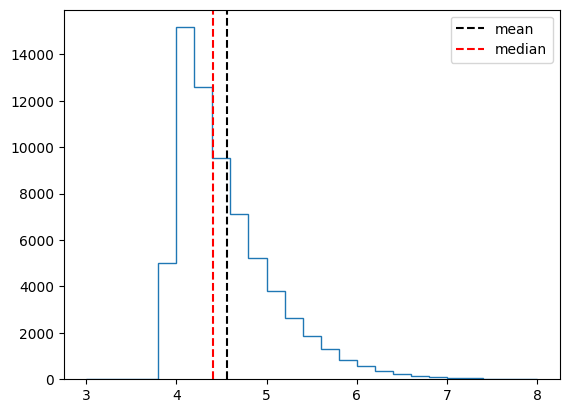

In [ ]:
plt.hist(fluxes.log10().numpy(), bins=25, histtype='step', range=(3, 8))
plt.axvline(fluxes.log10().mean(), linestyle='--', color='k', label='mean')
plt.axvline(fluxes.log10().median(), linestyle='--', color='r', label='median')
plt.legend()

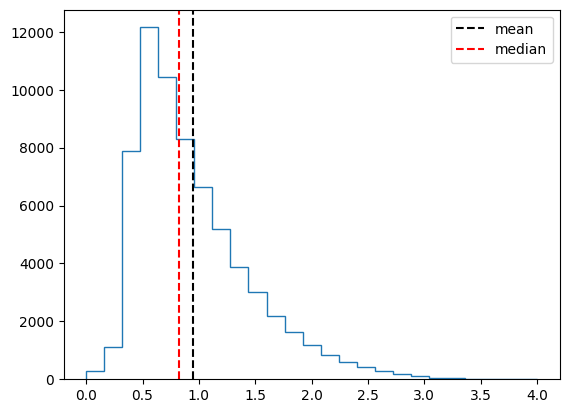

In [ ]:
plt.hist(snr.log10().numpy(), bins=25, histtype='step', range=(0, 4))
plt.axvline(snr.log10().mean(), linestyle='--', color='k', label='mean')
plt.axvline(snr.log10().median(), linestyle='--', color='r', label='median')
plt.legend()

In [ ]:
fluxes_noisy = (images - background).sum(dim=(1, 2, 3))
fluxes_noisy.shape

torch.Size([66648])

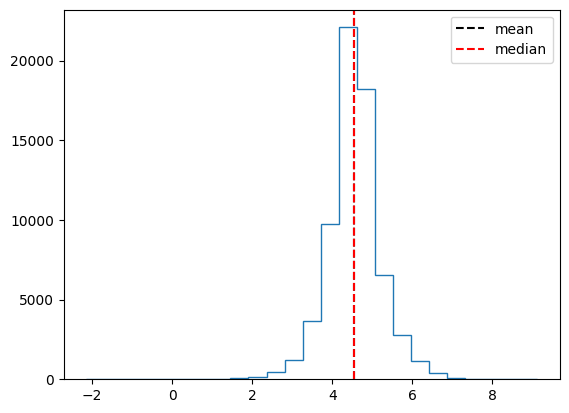

In [ ]:
plt.hist(fluxes_noisy.abs().log10().numpy(), bins=25, histtype='step')
plt.axvline(fluxes_noisy.abs().log10().mean(), linestyle='--', color='k', label='mean')
plt.axvline(fluxes_noisy.abs().log10().median(), linestyle='--', color='r', label='median')
plt.legend()

/home/imendoza/bliss/bliss/plotting.py:256: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y_bin: np.ndarray = y[keep_x]


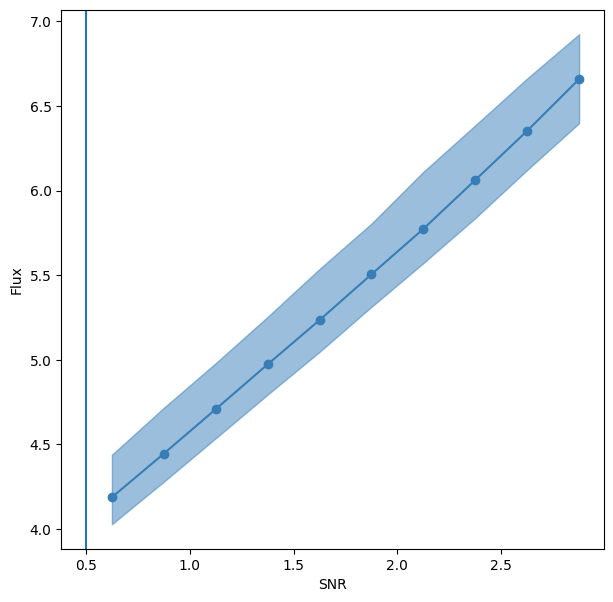

In [ ]:
from bliss.plotting import scatter_shade_plot
fig, ax = plt.subplots(1, 1, figsize=(7,7))
scatter_shade_plot(ax, snr.log10(), fluxes.log10(), xlims=(0.5, 3.0), delta=0.25, qs=(0.025, 0.975))
plt.ylabel("Flux")
plt.xlabel("SNR")
plt.axvline(0.5)

(3.5, 7.0)

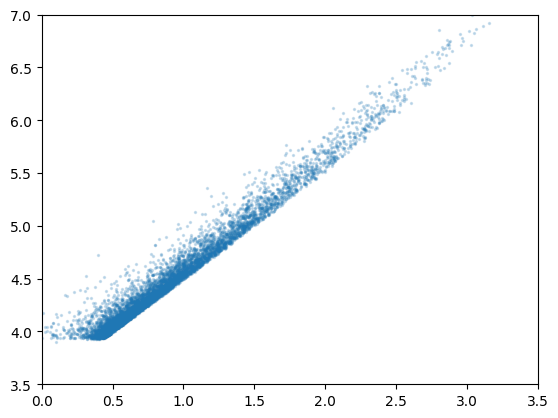

In [ ]:
# first simple scatter plot of flux and snr
plt.scatter(snr.log10()[::10], fluxes.log10()[::10], alpha=0.2, s=2)
plt.xlim(0, 3.5)
plt.ylim(3.5, 7)

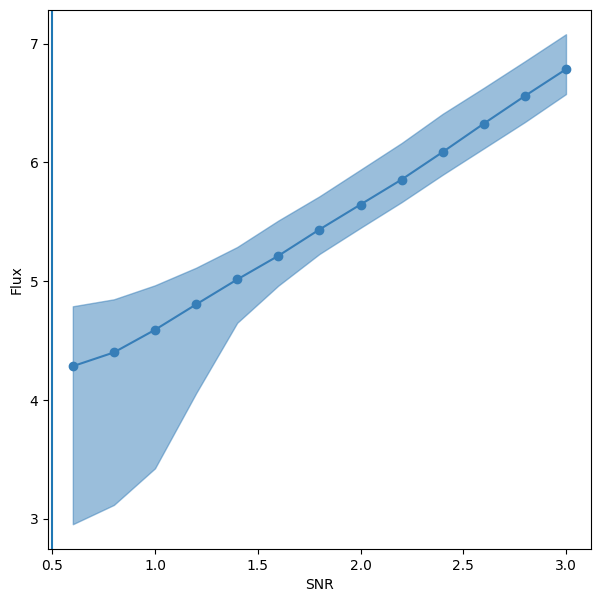

In [ ]:
from bliss.plotting import scatter_shade_plot
fig, ax = plt.subplots(1, 1, figsize=(7,7))
scatter_shade_plot(ax, snr.log10(), fluxes_noisy.abs().log10(), xlims=(0.5, 3.0), delta=0.2, qs=(0.025, 0.975))
plt.ylabel("Flux")
plt.xlabel("SNR")
plt.axvline(0.5)

# Individual galaxy flux scatter

In [ ]:
import galsim

from bliss.datasets.background import add_noise_and_background 
hlr = 0.8
flux = 10**(4.8)
e1 = 0.1
e2 = 0.0

slen = 41

gal = galsim.Gaussian(half_light_radius=hlr, flux=flux)
gal = gal.shear(e1=e1, e2=e2)
gal_conv  = galsim.Convolve([gal, psf])

img = gal_conv.drawImage(nx=slen, ny=slen, scale=0.2)
im = torch.from_numpy(img.array)

im_noisy = add_noise_and_background(im, background)

thres = np.sqrt(flux + background) * 0.1
mask = im > thres
mask.sum(), 41**2, thres

(tensor(255), 1681, 49.67385373091355)

In [ ]:
print(get_snr(im.reshape(1, 1, slen, slen), background))

tensor([10.0734])


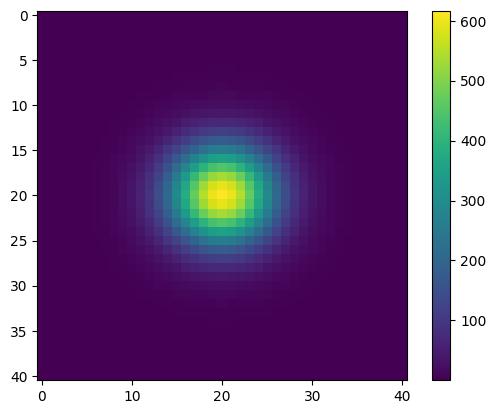

In [ ]:
plt.imshow(im)
plt.colorbar()

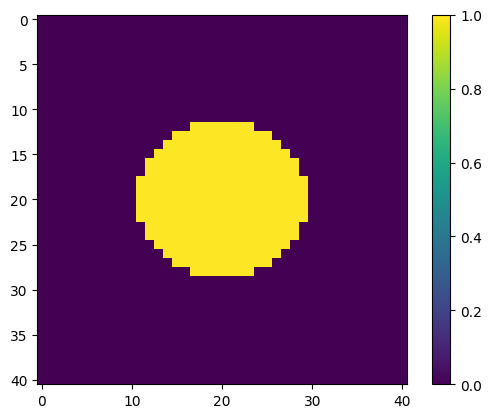

In [ ]:
plt.imshow(mask)
plt.colorbar()

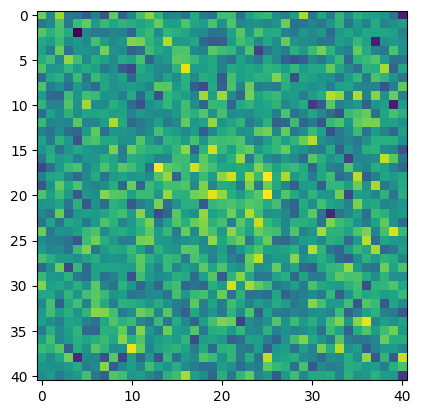

In [ ]:
plt.imshow(im_noisy)

In [ ]:
# flux scatter from noise
fluxes = []
for ii in range(10000): 
    im_noisy = add_noise_and_background(im, background) - background
    fluxes.append(im_noisy[mask].sum())

(array([1.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 6.000e+00, 1.800e+01,
        3.300e+01, 9.300e+01, 2.060e+02, 3.900e+02, 5.760e+02, 8.030e+02,
        1.075e+03, 1.264e+03, 1.371e+03, 1.208e+03, 1.023e+03, 7.260e+02,
        5.380e+02, 3.440e+02, 1.810e+02, 9.000e+01, 3.200e+01, 1.300e+01,
        5.000e+00]),
 array([23670.90625   , 25932.2421875 , 28193.578125  , 30454.9140625 ,
        32716.25195312, 34977.5859375 , 37238.921875  , 39500.26171875,
        41761.59765625, 44022.93359375, 46284.26953125, 48545.60546875,
        50806.94140625, 53068.27734375, 55329.61328125, 57590.94921875,
        59852.28515625, 62113.62109375, 64374.95703125, 66636.296875  ,
        68897.6328125 , 71158.96875   , 73420.3046875 , 75681.640625  ,
        77942.9765625 , 80204.3125    ]),
 <BarContainer object of 25 artists>)

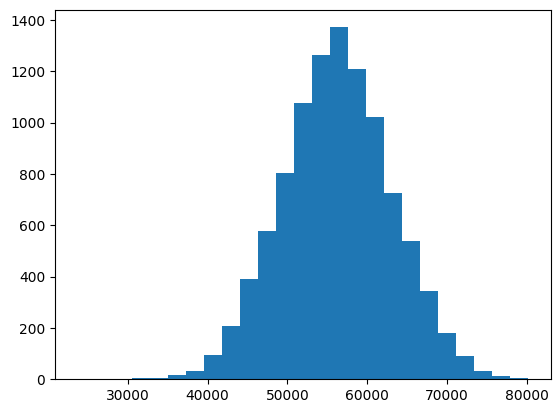

In [ ]:
fluxes = np.array(fluxes)
plt.hist(fluxes, bins=25)

In [ ]:
flux / fluxes.std()

9.236246965595141

In [ ]:
flux

63095.7344480193